ZZ Feature Map Algorithm 1 test

Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit import BasicAer
from qiskit import Aer, transpile

from qiskit.utils import QuantumInstance
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.kernels import FidelityQuantumKernel

import qiskit_machine_learning.kernels
from qiskit.primitives import Sampler
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.datasets import ad_hoc_data


from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import r2_score, accuracy_score
from sklearn.model_selection import train_test_split
import random
from sklearn.datasets import make_blobs

import scipy.io
import pandas as pd
from qiskit.providers.aer import AerError
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit.algorithms.state_fidelities import ComputeUncompute
algorithm_globals.random_seed = 0

dataset_list = []

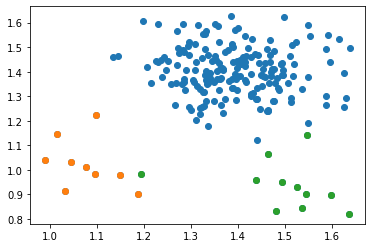

In [2]:
random.seed(13)
seed = 0
x, y = make_blobs(n_samples=190, centers=1, cluster_std=.1, center_box=(1.4, 1.4), random_state=seed)

out1x, out1y = make_blobs(n_samples=9, centers=1, cluster_std=.1, center_box=(1, 1), random_state=seed)
out2x, out2y = make_blobs(n_samples=11, centers=1, cluster_std=.1, center_box=(3.2, 0.01), random_state=seed)

plt.show()

# prepare data for One-Class model
y[y == 0] = 1
out1y[out1y==0] = -1 
out2y[out2y==0] = -1 

x = np.append(x, out1x, axis = 0)
y = np.append(y, out1y, axis = 0)

x = np.append(x, out2x, axis = 0)
y = np.append(y, out2y, axis = 0)

# Plot to see data
plt.scatter(x[:,0], x[:,1])
plt.scatter(out1x[:,0], out1x[:,1])
plt.scatter(out2x[:,0], out2x[:,1])

plt.show()

# Add data to dataset_list
dataset_list.append([x,y])

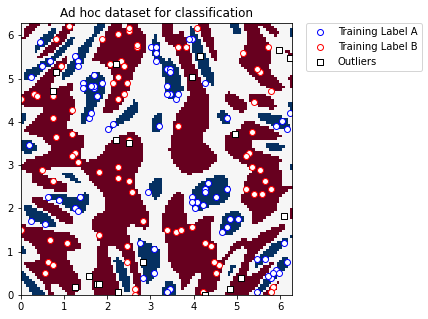

In [3]:
# Second dataset: ZZFeatureMap ad_hoc data
adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=80,
    test_size=0,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)
train_features_out, train_labels_out, _, _ = ad_hoc_data(
    training_size=10,
    test_size=0,
    n=adhoc_dimension,
    gap=0.7,
    plot_data=False,
    one_hot=False,
    include_sample_total=False,
)
# adhoc_total[adhoc_total == 0] = 1

# print(train_features)
# print(train_labels)

# Change labels for One-Class
train_labels_out[train_labels_out != -1] = -1

# Now we have to add the outliers
train_features = np.append(train_features, train_features_out, axis = 0)
train_labels = np.append(train_labels, train_labels_out, axis = 0)


plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap="RdBu",
    extent=[0, 2 * np.pi, 0, 2 * np.pi],
)

plt.scatter(
    train_features[np.where(train_labels[:] == 0), 0],
    train_features[np.where(train_labels[:] == 0), 1],
    marker="o",
    facecolors="w",
    edgecolors="b",
    label="Training Label A",
)
plt.scatter(
    train_features[np.where(train_labels[:] == 1), 0],
    train_features[np.where(train_labels[:] == 1), 1],
    marker="o",
    facecolors="w",
    edgecolors="r",
    label="Training Label B",
)
plt.scatter(
    train_features[np.where(train_labels[:] == -1), 0],
    train_features[np.where(train_labels[:] == -1), 1],
    marker="s",
    facecolors="w",
    edgecolors="k",
    label="Outliers",
)


plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Ad hoc dataset for classification")

plt.show()

# We don't need the second label for one-class SVMs, so change 0 label to 1
train_labels[train_labels == 0] = 1


# add data to dataset_list
dataset_list.append([train_features,train_labels])

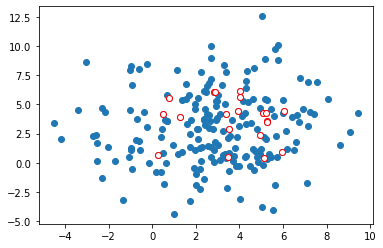

In [4]:
# Third dataset, create blob and add zz feature map data to it
random.seed(13)
seed = 23
x, y = make_blobs(n_samples=190, centers=1, cluster_std=3, center_box=(3, 3), random_state=seed)
train_features_out2, train_labels_out2, _, _ = ad_hoc_data(
    training_size=10,
    test_size=0,
    n=adhoc_dimension,
    gap=0.5,
    plot_data=False,
    one_hot=False,
    include_sample_total=False,
)

# prepare data for One-Class model
y[y == 0] = 1
train_labels_out2[train_labels_out2 != -1] = -1 

# add outliers to data
x = np.append(x, train_features_out2, axis = 0)
y = np.append(y, train_labels_out2, axis = 0)

# Plot to see data
plt.scatter(x[:,0], x[:,1])
plt.scatter(
    train_features_out2[np.where(train_labels_out2[:] == -1), 0],
    train_features_out2[np.where(train_labels_out2[:] == -1), 1],
    marker="o",
    facecolors="w",
    edgecolors="r",
    label="Training Label B",
)

plt.show()

# Add data to dataset_list
dataset_list.append([x,y])


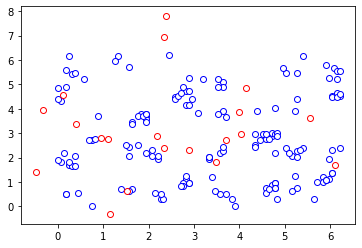

In [5]:
adhoc_dimension = 2
train_features, train_labels, _,_ = ad_hoc_data(
    training_size=80,
    test_size=0,
    n=adhoc_dimension,
    gap=0.6,
    plot_data=False,
    one_hot=False,
    include_sample_total=False,
)
x, y = make_blobs(n_samples=20, centers=3, cluster_std=2, center_box=(3, 3), random_state=111)

# prepare data for One-Class model
train_labels[train_labels == 0] = 1
y[y != -1] = -1 

# add outliers to data
train_features = np.append(train_features, x, axis = 0)
train_labels = np.append(train_labels, y, axis = 0)

# Plot to see data
plt.scatter(
    train_features[np.where(train_labels[:] == 1), 0],
    train_features[np.where(train_labels[:] == 1), 1],
    marker="o",
    facecolors="w",
    edgecolors="b",
    label="Training Label A",
)
plt.scatter(
    x[np.where(y[:] == -1), 0],
    x[np.where(y[:] == -1), 1],
    marker="o",
    facecolors="w",
    edgecolors="r",
)

plt.show()

# Add data to dataset_list
dataset_list.append([train_features,train_labels])

Quantum Function for OneClass (Algorithm 1)

In [6]:
# First algorithm, returns trained model
def Algorithm1(X, y, reps, shots, outliers_fraction,entanglement="linear", num_features = 2, seed = 0, predict=True):
    # Define ZZFeatureMap using inputs
    feature_map = ZZFeatureMap(feature_dimension = num_features, reps = reps, entanglement=entanglement)
    # Define Simulator we want to use
#     backend = BasicAer.get_backend("qasm_simulator")
    # Which simulator and instance to use
#     simulator = QuantumInstance(backend, shots=5, seed_simulator=seed, seed_transpiler=seed)
#     waveform_kernel = QuantumKernel(feature_map=Feature_map, quantum_instance=simulator)
#     precomp_kernel = waveform_kernel.evaluate(x)
    # Calculates probabilities of bit results from quantum circuits
    sampler = Sampler()
    # uses sampler to calculate state fidelity of 2 quantum circuits
    fidelity = ComputeUncompute(sampler=sampler)
    # Translates data with base state fidelity distance metric
    kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)
    # Evaluate data to make it usable for OC-QSVM
    precomp_kernel = kernel.evaluate(X)
    precomp_kernel_real = np.real(precomp_kernel)
    
    svm = OneClassSVM(kernel = 'precomputed', verbose=True, nu=outliers_fraction)
    svm.fit(precomp_kernel_real)
    if predict:
        y_pred = svm.predict(precomp_kernel_real)
        #TODO save to matrix
        print(y_pred)
        print(accuracy_score(y, y_pred))
    return svm

Showcase of Algorithm 1

In [7]:
dataset_count = 0
outliers_fraction=20/210
for X, y in dataset_list:
    dataset_count = dataset_count + 1
    print("For dataset: {}".format(dataset_count))
    for i in range(2,3):
        print("For reps: {}".format(i))
        Algorithm1(X, y, i, 1, outliers_fraction=outliers_fraction)

# fit data to OneClassSVM
# svm.fit(precomp_kernel_real)

For dataset: 1
For reps: 2
[LibSVM][ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1 -1  1 -1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1
 -1 -1 -1 -1 -1 -1  1  1  1 -1  1 -1  1  1 -1  1  1 -1]
0.9238095238095239
For dataset: 2
For reps: 2
[LibSVM][ 1 -1  1 -1  1  1  1 -1  1  1  1  1 -1  1 -1  1  1  1  1  1  1  1  1  1
  1 -1 -1 -1  1 -1  1  1 -1  1  1  1  1  1  1  1  1 -1 -1  1 -1 -1  1  1
 -1  1  1  1 -1 -1 -1 -1 -1 -1  1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1  1  1
  1 -1 -1 -1  1 -1  1  1 -1  1  1  1  1  1  1  1  1 

Comparison to other One-Class SVM methods

In [8]:
other_kernel_list = ['rbf', 'linear', 'poly', 'sigmoid']
outliers_fraction=20/210
dataset_count = 0
for X,y in dataset_list:
    dataset_count = dataset_count + 1
    print("For dataset: {}".format(dataset_count))
    for kernel in other_kernel_list:
        svm_classical = OneClassSVM(kernel = kernel, verbose=True,  nu=outliers_fraction)
        svm_classical.fit(X)

        y_pred = svm_classical.predict(X)
        print("{}: ".format(kernel))
        print(accuracy_score(y, y_pred))
        print(y_pred)


For dataset: 1
[LibSVM]rbf: 
0.8904761904761904
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1 -1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1
  1  1 -1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1
  1  1 -1 -1  1  1 -1  1  1 -1  1  1  1  1 -1 -1  1  1]
[LibSVM]linear: 
0.9714285714285714
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1

Second algorithm function

In [ ]:
def Algorithm1(X, y, reps, shots, outliers_fraction,entanglement="linear", num_features = 2, seed = 0, predict=True):
    # Define ZZFeatureMap using inputs
    feature_map = ZZFeatureMap(feature_dimension = num_features, reps = reps, entanglement=entanglement)
    # Calculates probabilities of bit results from quantum circuits
    sampler = Sampler()
    # uses sampler to calculate state fidelity of 2 quantum circuits
    fidelity = ComputeUncompute(sampler=sampler)
    # Translates data with base state fidelity distance metric
    kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)
    # Evaluate data to make it usable for OC-QSVM
    precomp_kernel = kernel.evaluate(X)
    precomp_kernel_real = np.real(precomp_kernel)
    
    svm = OneClassSVM(kernel = 'precomputed', verbose=True, nu=outliers_fraction)
    svm.fit(precomp_kernel_real)
    if predict:
        y_pred = svm.predict(precomp_kernel_real)
        #TODO save to matrix
        print(y_pred)
        print(accuracy_score(y, y_pred))
    return svm

Second algorithm attempt

In [7]:
Qseed = 0
num_features = len(x[0])
backend = BasicAer.get_backend("qasm_simulator")
simulator = QuantumInstance(backend, shots=5, seed_simulator=Qseed, seed_transpiler=Qseed)
waveform_kernel = FidelityQuantumKernel()
precomp_kernel = waveform_kernel.evaluate(x)
precomp_kernel_real = np.real(precomp_kernel)
outliers_fraction = 9/200
svm = OneClassSVM(kernel = 'precomputed', verbose=True, nu=outliers_fraction)

# fit data to OneClassSVM
svm.fit(precomp_kernel_real)

[LibSVM]

OneClassSVM(kernel='precomputed', nu=0.045, verbose=True)

In [8]:
y_pred = svm.predict(precomp_kernel_real)
print(accuracy_score(y, y_pred))

print(y)
print(y_pred)

0.9617224880382775
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 

In [1]:
import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline

matplotlib.rcParams["contour.negative_linestyle"] = "solid"


def QuantumOneClassSVM(nu, gamma):
    precomp_kernel = waveform_kernel.evaluate(X_train)
    precomp_kernel_real = np.real(precomp_kernel)
    svm = OneClassSVM(kernel = 'precomputed', verbose=True)
    # fit data to OneClassSVM
    svm.fit(precomp_kernel_real)

In [9]:


Qseed = 0
num_features = len(x[0])
adhoc_feature_map = ZZFeatureMap(feature_dimension=num_features, reps=2, entanglement="linear")
adhoc_kernel = FidelityQuantumKernel(feature_map=adhoc_feature_map)

In [10]:
precomp_kernel = adhoc_kernel.evaluate(x)
precomp_kernel_real = np.real(precomp_kernel)
outliers_fraction = 9/200
svm = OneClassSVM(kernel = 'precomputed', verbose=True, nu=outliers_fraction)

# fit data to OneClassSVM
svm.fit(precomp_kernel_real)

[LibSVM]

OneClassSVM(kernel='precomputed', nu=0.045, verbose=True)

In [12]:
y_pred = svm.predict(precomp_kernel_real)
print(accuracy_score(y, y_pred))

print(y)
print(y_pred)

0.9617224880382775
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 

In [1]:
pwd

'C:\\Users\\slang'